<a href="https://colab.research.google.com/github/CUknot/NLP/blob/main/HW3_1_Key_Value_Attention_for_Thai_Karaoke_MT_to_student_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key-Value Attention for Thai Karaoke Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [ ]:
!pip install lightning wandb
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 29.5 MB/s eta 0:00:00
--2025-01-25 14:38:34--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2025-01-25 14:38:35--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubuserco

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%matplotlib inline
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')
import torch
# import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

```
ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak
```


In [ ]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2025-01-25 14:39:18--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv’

mp_name_th_en.csv   100%[===================>] 316.80K  --.-KB/s    in 0.03s   

2025-01-25 14:39:18 (8.96 MB/s) - ‘mp_name_th_en.csv’ saved [324399/324399]



In [ ]:
import csv

with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [ ]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [ ]:
#Preprocessing
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))
data_size, vocab_size = len(name_th), len(input_chars)+1
output_vocab_size = len(output_chars)+2#+2 for special end of sentence token/PADDING
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
maxlen_out = len( max(name_en, key=len)) #max input length

There are 10887 lines and 65 unique characters in your input data.


In [ ]:
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 19


In [ ]:
def build_vocab(characters, special_tokens):
    """
    Builds a vocabulary from a set of characters and special tokens.
    Args:
        characters: A set or list of characters to include in the vocabulary.
        special_tokens: A list of special tokens to prepend to the vocabulary.

    Returns:
        vocab: A dictionary mapping each character/token to an index.
        reverse_vocab: A dictionary mapping each index back to its character/token.
    """
    vocab = {token: idx for idx, token in enumerate(special_tokens)}
    for char in characters:
        if char not in vocab:
            vocab[char] = len(vocab)
    reverse_vocab = {idx: char for char, idx in vocab.items()}
    return vocab, reverse_vocab

# Example Thai and English characters
thai_characters = set("".join(name_th))  # Characters from Thai names
english_characters = set("".join(name_en))  # Characters from English names

# Define special tokens
special_tokens = ["<pad>", "<eow>"]

# Build vocabularies
thai_vocab, thai_reverse_vocab = build_vocab(thai_characters, special_tokens)
english_vocab, english_reverse_vocab = build_vocab(english_characters, special_tokens)

In [ ]:
print(f"thai_vocab: {thai_vocab}")
print(f"english_vocab: {english_vocab}")

thai_vocab: {'<pad>': 0, '<eow>': 1, 'ั': 2, 'ิ': 3, 'โ': 4, '๊': 5, 'ฌ': 6, 'ุ': 7, 'ภ': 8, 'จ': 9, 'ป': 10, '้': 11, 'ื': 12, 'ส': 13, 'ฑ': 14, 'ก': 15, 'า': 16, 'ด': 17, 'ฏ': 18, '็': 19, 'ธ': 20, 'ไ': 21, 'พ': 22, 'ใ': 23, 'ท': 24, 'ฎ': 25, 'ห': 26, 'ศ': 27, 'ซ': 28, 'ง': 29, '่': 30, 'แ': 31, 'ต': 32, 'ณ': 33, 'ู': 34, 'บ': 35, 'ค': 36, 'ฮ': 37, 'ฬ': 38, 'ฝ': 39, 'ษ': 40, 'ญ': 41, 'ข': 42, 'ม': 43, 'ึ': 44, 'ฆ': 45, '๋': 46, 'ี': 47, 'ฟ': 48, 'ล': 49, 'ถ': 50, 'ผ': 51, ' ': 52, 'เ': 53, 'ฒ': 54, '์': 55, 'อ': 56, 'ำ': 57, 'ฐ': 58, 'น': 59, 'ฉ': 60, 'ะ': 61, 'ว': 62, 'ช': 63, 'ย': 64, 'ร': 65}
english_vocab: {'<pad>': 0, '<eow>': 1, 'l': 2, 'y': 3, 'i': 4, '-': 5, 's': 6, 'w': 7, 'o': 8, 'e': 9, 'c': 10, 'k': 11, 'd': 12, 'r': 13, 'n': 14, 'a': 15, 'p': 16, 'u': 17, 'h': 18, 'f': 19, 't': 20, 'm': 21, 'b': 22, 'g': 23}


In [ ]:
input_encode = lambda s: [thai_vocab[c] for c in s] # encoder: take a string, output a list of integers
input_decode = lambda l: ''.join([thai_reverse_vocab[i] for i in l]) # decoder: take a list of integers, output a string
output_encode = lambda s: [english_vocab[c] for c in s] # encoder: take a string, output a list of integers
output_decode = lambda l: ''.join([english_reverse_vocab[i] for i in l]) # decoder: take a list of integers, output a string

In [ ]:
X = []
for line in name_th:
    line = [l for l in line] #change from string to list
    X.append(torch.tensor(input_encode(line)))
Y = []
for line in name_en:
    line = [l for l in line] #change from string to list
    Y.append(torch.tensor(output_encode(line)))

X = nn.utils.rnn.pad_sequence(X, batch_first = True)
Y = nn.utils.rnn.pad_sequence(Y, batch_first = True)

In [ ]:
print(f"Encoded Thai names: {X}")
print(f"Encoded English names: {Y}")

Encoded Thai names: tensor([[21, 15, 65,  ...,  0,  0,  0],
        [22,  2, 63,  ...,  0,  0,  0],
        [20, 47, 65,  ...,  0,  0,  0],
        ...,
        [15, 43, 49,  ...,  0,  0,  0],
        [ 8, 62,  2,  ...,  0,  0,  0],
        [22,  2, 54,  ...,  0,  0,  0]])
Encoded English names: tensor([[11, 13, 15,  ...,  0,  0,  0],
        [16, 18, 15,  ...,  0,  0,  0],
        [20, 18,  4,  ...,  0,  0,  0],
        ...,
        [11, 15, 21,  ...,  0,  0,  0],
        [16, 18, 15,  ...,  0,  0,  0],
        [16, 18, 15,  ...,  0,  0,  0]])


In [ ]:
X.shape

torch.Size([10887, 20])

In [ ]:
Y.shape

torch.Size([10887, 19])

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class NameDataset(Dataset):
  def __init__(self, X, y):
      self.encoded = X.long()
      self.label = y.long()

  def __getitem__(self, idx):
      return {"x" :self.encoded[idx], "y":self.label[idx]}

  def __len__(self):
      return len(self.encoded)

In [ ]:
class NameDataModule(L.LightningDataModule):

  def __init__(self, train_data, y, batch_size, num_workers=0):
      super().__init__()
      self.train_data = train_data
      self.y = y
      self.batch_size = batch_size
      self.num_workers = num_workers


  def setup(self, stage: str):
      pass

  def collate_fn(self, batch):
      one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(thai_vocab)) for b in batch])
      return {"x": one_hot_x.float(), "y": torch.stack([b["y"] for b in batch])}

  def train_dataloader(self):
      train_dataset = NameDataset(self.train_data, self.y)
      return DataLoader(
              train_dataset,
              batch_size=self.batch_size,
              num_workers=self.num_workers,
              shuffle=True,
              collate_fn=self.collate_fn
        )


# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [ ]:
def one_step_attention(h, s_prev, linear_1, linear_2):

    #Split into Key-Value
    key, value = torch.split(h, h.shape[-1] // 2, dim=-1)
    #do concat with s_prev.
    #hint: you will need to use s_prev.repeat(...) somehow so that it has the same dimension as the key
    #hint2: s_prev.unsqueeze() could also be useful


    #Attention function###
    # use layer(s) from your model to calculate attention_scores and then softmax
    # calculate a context vector
    s_prev = s_prev.unsqueeze(1).repeat(1, key.shape[1], 1)
    concat = torch.cat([key, s_prev], dim=-1)
    e = F.tanh(linear_1(concat))
    energies = linear_2(e)
    attention_scores = F.softmax(energies, dim=1)
    temp = attention_scores * value
    context = torch.sum(temp, dim=1)

    return context, attention_scores

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [ ]:
class AttentionModel(L.LightningModule):
    def __init__(self):

        super().__init__()
        self.n_h = 32   #hidden dimensions for encoder
        self.n_s = 64  #hidden dimensions for decoder
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

        #encoder can be any RNN of your choice
        # Encoder: Bidirectional LSTM
        self.lstm = nn.LSTM(input_vocab_size, self.n_h, bidirectional=True, batch_first=True)
        self.num_directions = 2  # Bidirectional LSTM

        #decoder has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        # Decoder: LSTMCell
        self.decoder_lstm_cell = nn.LSTMCell(self.n_s // 2, self.n_s)
        self.output_layer = nn.Linear(self.n_s, len(english_vocab))

        # Output layer
        self.output_layer = nn.Linear(self.n_s, output_vocab_size)

        #attention
        # Attention mechanism layers
        self.fc1 = nn.Linear(self.n_h*2*3//2, self.n_h)
        self.fc2 = nn.Linear(self.n_h, 1)


    def forward(self, src, return_attention=False): #use return_attention only when you want to get the attention scores for visualizing
        #pass the input to the encoder
        lstm_out, _ = self.lstm(src)

        #Initialize the LSTM states. We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        #These states will get updated while we are decoding
        decoder_s = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)
        decoder_c = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)

        #Iterate until max_output_length (Decoding)
        prediction = torch.zeros((src.shape[0], maxlen_out, len(english_vocab))).to(self.decoder_lstm_cell.weight_ih.device)
        attention_scores = [] #to store the score for each step
        for t in range(maxlen_out):

            #Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(lstm_out, decoder_s, self.fc1, self.fc2)

            # Feed the context vector to the decoder.
            decoder_s, decoder_c = self.decoder_lstm_cell(context, (decoder_s, decoder_c))

            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)

            # Put the predicted output into the list for this timestep
            prediction[:, t] = out

            attention_scores.append(attention_score)

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src = batch['x']
        target = batch['y']
        max_output_length = target.shape[1]

        # Forward pass
        predictions, _ = self(src, max_output_length)
        predictions = predictions.reshape(-1, self.output_layer.out_features)
        target = target.reshape(-1)

        # Compute loss
        loss = self.criterion(predictions, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        # Extract the input data from the batch
        src = batch['x']

        with torch.no_grad():  # Disable gradient computation for inference
            # Get the predictions and attention scores from the model
            prediction, attention_scores = self(src, return_attention=True)

            # Apply softmax to the predictions to get probabilities
            prediction = F.softmax(prediction, dim=-1)

            # Get the index of the highest probability for each prediction
            prediction = torch.argmax(prediction, dim=-1)

            # Print the decoded predictions as strings
            for pred in prediction:
                print("".join(output_decode(pred.cpu().numpy())))

            return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
# Example setup
input_vocab_size = len(thai_vocab)  # Size of the input vocabulary
output_vocab_size = len(english_vocab)  # Size of the output vocabulary
learning_rate = 1e-3

# Initialize the model
model = AttentionModel()

In [ ]:
data_module = NameDataModule(X, Y, batch_size=32, num_workers=2)

In [ ]:
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="hw3.1_attention")

In [ ]:
trainer = L.Trainer(
    max_epochs=100,
    logger=wandb_logger
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0      | train
1 | lstm              | LSTM             | 25.6 K | train
2 | decoder_lstm_cell | LSTMCell         | 25.1 K | train
3 | output_layer      | Linear           | 1.6 K  | train
4 | fc1               | Linear           | 3.1 K  | train
5 | fc2               | Linear           | 33     | train
---------------------------------------------------------------
55.4 K    Trainable params
0         Non-trainable params
5

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

Example Output:
```
prayutthatha</s></s>aa</s></s>a</s>
somchai</s></s></s></s>a</s></s>a</s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s></s>
newin</s>i</s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s>he</s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s>i</s></s></s></s>
```

<font color='blue'>Paste your model predictions in MyCourseVille</font>

In [ ]:
EXAMPLES = ['ประยุทธ','สมชาย','ธนาธร','เนวิน','สุเทพ','ประวิตร์','ชัชชาติ', 'กิตติพัฒน์']

In [ ]:
model = AttentionModel.load_from_checkpoint("/content/hw3.1_attention/6wyxe0lf/checkpoints/epoch=99-step=34100.ckpt")
model.eval()

AttentionModel(
  (criterion): CrossEntropyLoss()
  (lstm): LSTM(66, 32, batch_first=True, bidirectional=True)
  (decoder_lstm_cell): LSTMCell(32, 64)
  (output_layer): Linear(in_features=64, out_features=24, bias=True)
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
# Prepare the input data
predict_data = []
for name in EXAMPLES:
    name_list = [char for char in name]  # Convert string to a list of characters
    predict_data.append(torch.tensor(input_encode(name_list)))  # Encode the name and append to the list

# Define a custom collate function for batching
def collate_fn(batch):
    # Perform one-hot encoding on each batch item and stack them together
    one_hot_x = torch.stack([F.one_hot(item["x"], num_classes=len(thai_vocab)) for item in batch])
    return {"x": one_hot_x.float()}  # Return the one-hot encoded data as a float tensor

# Pad the sequence to ensure consistent length for batching
predict_data = nn.utils.rnn.pad_sequence(predict_data, batch_first=True)

# Create a dataset for predictions with placeholder labels (0 for each item)
predict_dataset = NameDataset(predict_data, torch.tensor([0] * len(predict_data)))

# Load the data into a DataLoader, using the custom collate function
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0)


In [ ]:
output = trainer.predict(model, predict_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

prayuttta<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
samchaii<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
thanathan<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
nawen<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
suthee<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
prawat<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
chaacchtt<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
kittiphaa<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


## TODO 5: Show your visualization of attention scores on one of your example

<font color='blue'>Paste your visualization image in MyCourseVille</font>

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
prediction, attention_scores = zip(*output)

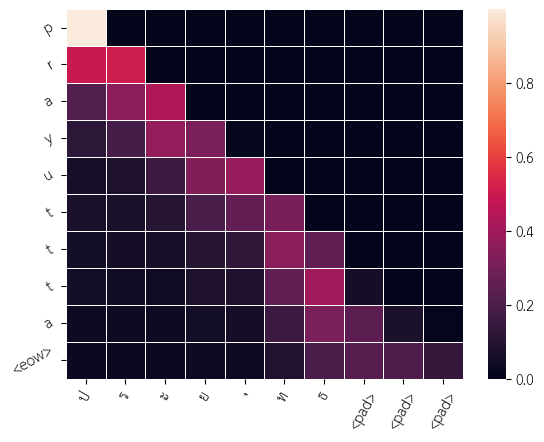

In [ ]:
# Decode the prediction (without trailing zeros)
output_text = "".join(output_decode(c) for c in prediction[0][:np.argmax(prediction[0] == 0)].cpu().numpy())
output_text = list(output_text.replace('<pad>', ""))
output_text.append('<eow>')

# Prepare xlabels
xlabels = [c for c in EXAMPLES[0]]  # Use the original EXAMPLES string
xlabels.append('<pad>')  # Add <PAD> for the padding token

# Adjust the attention matrix to match the length of output_text
attn_viz = torch.stack(attention_scores[0]).squeeze().cpu().numpy()
attn_viz = attn_viz.transpose(1,0)

# Adjust the attention matrix and xlabels to match
attn_viz = attn_viz[:, :len(output_text)]
attn_viz = attn_viz.T  # Transpose it to match the visualization format

# Ensure xlabels matches the number of columns in the attention matrix
while len(xlabels) < attn_viz.shape[1]:
    xlabels.append('<pad>')  # Extend xlabels with <PAD> until it matches

# Create the heatmap
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_yticklabels(output_text, rotation=30)
ax.set_xticklabels(xlabels, rotation=60)
plt.show()
